# Определение стоимости автомобилей с помощью полносвязных нейронных сетей

Это самостоятельное развитие учебного проекта `car_prices_prediction.ipynb`, здесь вместо классического ML будут использоваться методы DL в релизации фреймворка PyTorch. Данные уже обработаны в предыдущем проекте, здесь мы применим другую технику кодирования категориальных переменных.

__________
Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

**Цель проекта:** Построить модель глубокого обучения для определения стоимости автомобиля по его характеристикам.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-0"><span class="toc-item-num">0&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка признаков</a></span><ul class="toc-item"><li><span><a href="#Кодирование-признаков" data-toc-modified-id="Кодирование-признаков-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Кодирование признаков</a></span></li><li><span><a href="#Нормировка-признаков" data-toc-modified-id="Нормировка-признаков-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Нормировка признаков</a></span></li></ul></li><li><span><a href="#Создание-моделей" data-toc-modified-id="Создание-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Создание моделей</a></span></li><li><span><a href="#Цикл-для-обучения-модели" data-toc-modified-id="Цикл-для-обучения-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Цикл для обучения модели</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Импорт библиотек

In [1]:
# Импорты сторонних библиотек
import pandas as pd
import sklearn
import numpy
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

# Импорты модулей для текущего проекта
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
                            StandardScaler, 
                            TargetEncoder)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from datetime import datetime

# Константы
RANDOM_STATE = 23
LOSS = 'RMSE' # Функция потерь при обучении сети
BATCH_SIZE = 64 # Размер батча

# Настройки отображения
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
class RMSELoss(nn.Module):
    '''
    Класс для функции потерь RMSE
    '''
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))

In [3]:
if LOSS=='MAE':
    LOSS_FUN = nn.L1Loss()
if LOSS=='MSE':
    LOSS_FUN = nn.MSELoss()
if LOSS=='RMSE':
    LOSS_FUN = RMSELoss()

In [4]:
LOSS_FUN

RMSELoss(
  (mse): MSELoss()
)

## Подготовка признаков

### Кодирование признаков

In [5]:
df = pd.read_csv('ready_data.csv', sep=',')

In [6]:
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'kilometer', 'fuel_type', 'repaired', 'brand_model'],
      dtype='object')

Еще раз вспомним описание признаков, нужных для обучения:

    • vehicle_type — тип автомобильного кузова
    • registration_year — год регистрации автомобиля
    • gearbox — тип коробки передач
    • power — мощность (л. с.)
    • brand_model — модель и марка автомобиля
    • kilometer — пробег (км)
    • fuel_type — тип топлива
    • repaired — была машина в ремонте или нет
Целевой признак:  

    • price — цена (евро)

In [7]:
# Числовые признаки
num_features = ['registration_year', 'power', 'kilometer']

In [8]:
# Категориальные признаки
cat_features = ['brand_model', 'vehicle_type', 'gearbox', 'fuel_type']
cat_features

['brand_model', 'vehicle_type', 'gearbox', 'fuel_type']

In [9]:
target_encoder = TargetEncoder(target_type='continuous', random_state=RANDOM_STATE)

target_encoded_features = target_encoder.fit_transform(df[cat_features], df['price'])
target_encoder.get_feature_names_out()

array(['brand_model', 'vehicle_type', 'gearbox', 'fuel_type'],
      dtype=object)

In [10]:
target_encoded_features_df = pd.DataFrame(target_encoded_features, columns=target_encoder.get_feature_names_out())

In [11]:
# Разбиваем выборки на обучающую и тестовую

features = pd.concat([df[num_features + ['repaired']], target_encoded_features_df], axis=1)
target = df['price']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)

features.columns

Index(['registration_year', 'power', 'kilometer', 'repaired', 'brand_model',
       'vehicle_type', 'gearbox', 'fuel_type'],
      dtype='object')

In [12]:
features.sample(5)

,registration_year,power,kilometer,repaired,brand_model,vehicle_type,gearbox,fuel_type
68784,2002,109.0,150000,0,3169.761005,5007.124644,7095.570438,4821.516373
175967,2011,140.0,125000,0,4725.242676,5016.023387,4166.392679,4816.136837
211610,2003,107.0,150000,0,4080.422663,2742.720947,2611.414471,4809.009441
15244,2007,150.0,150000,0,3202.371704,6279.415611,4167.895054,4817.228302
228868,2010,143.0,60000,0,10044.217625,6931.295069,4166.392679,4816.136837


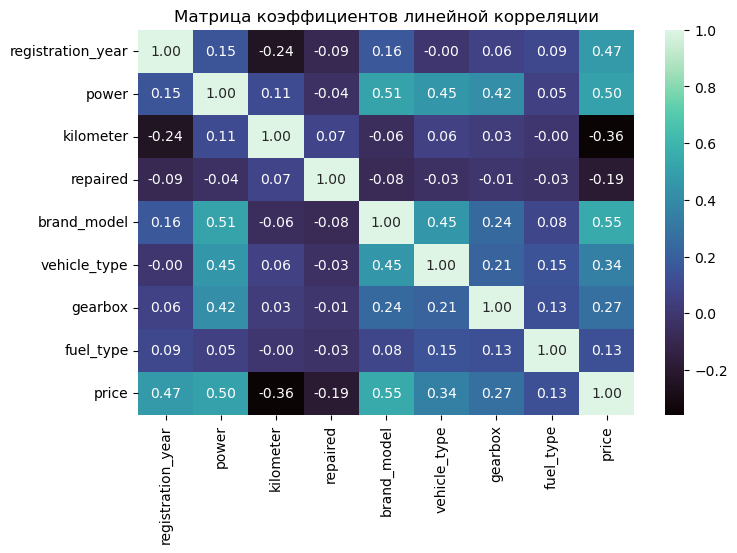

In [13]:
# Оценим линейную корреляцию признаков с целевой переменной

features_and_target = features.copy()
features_and_target['price'] = df['price']

plt.figure(figsize=(8,5))
sns.heatmap(features_and_target.corr(), annot=True, cmap=sns.color_palette("mako", as_cmap=True), fmt='.2f')
plt.title('Матрица коэффициентов линейной корреляции')
plt.show();

Строгой линейной зависимости цены от признаков нет.  
Наиболее выраженная линейная связь с ценой у признаков `registration_year`, `power`, `brand_model`.

### Нормировка признаков

In [14]:
scaler = StandardScaler().fit(X_train)
X_train_array = scaler.transform(X_train)
X_test_array = scaler.transform(X_test)

In [15]:
print('mean =', X_train_array.mean())
print('std =', X_train_array.std(axis=0))

mean = 2.9020881426900486e-16
std = [1. 1. 1. 1. 1. 1. 1. 1.]


In [16]:
# Выводим размеры выборок
X_train.shape
y_train.shape
X_test.shape
y_test.shape

(242286, 8)

(242286,)

(80763, 8)

(80763,)

In [17]:
# Переводим данные в формат тензоров
X_train = torch.from_numpy(X_train_array.reshape(-1, X_train.shape[1])).float()
X_test  = torch.from_numpy(X_test_array.reshape(-1, X_test.shape[1])).float()
y_train = torch.from_numpy(y_train.values.reshape(-1, 1)).float()
y_test  = torch.from_numpy(y_test.values.reshape(-1, 1)).float()

In [18]:
# Подготавливаем загрузчики и наборы данных для них
training_set = torch.utils.data.TensorDataset(X_train, y_train)
validation_set = torch.utils.data.TensorDataset(X_test, y_test)

training_loader   = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

total_samples = len(training_set) 
n_iterations = total_samples//BATCH_SIZE
print('Всего {} итераций для одной эпохи с рамером батча {}.'.format(n_iterations, BATCH_SIZE)) 

Всего 3785 итераций для одной эпохи с рамером батча 64.


## Создание моделей

In [19]:
class one_hidden_layer_NN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input = nn.Linear(input_size, input_size)
        self.hidden_1 = nn.Linear(input_size, input_size)
        self.output = nn.Linear(input_size, 1)
    
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden_1(x))
        x = self.output(x)
        return x

In [20]:
class two_hidden_layers_NN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input = nn.Linear(input_size, input_size*2)
        self.hidden_1 = nn.Linear(input_size*2, input_size*2)
        self.hidden_2 = nn.Linear(input_size*2, input_size*2)
        self.output = nn.Linear(input_size*2, 1)
    
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden_1(x))
        x = F.relu(self.hidden_2(x))
        x = self.output(x)
        return x

## Цикл для обучения модели

In [21]:
# Модель
model = two_hidden_layers_NN(X_train.shape[1])
# Функция потерь
loss_fun = LOSS_FUN
# Оптимизатор с шагом обучения
optimizer = torch.optim.Adam(model.parameters(), lr=.01)

# Планировщики для изменения шага обучения
scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=3
)

scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=3, 
    threshold=10, mode='max'
)

In [22]:
def train_and_evaluate(x_temp, y_temp):
    '''
    Функция обучения и валидации нейросетевой модели.
    '''
    last_loss = 0.
    losses = []
    
    for i, data in enumerate(training_loader):
        X, y = data
        
        # Зануляем градиенты для каждого батча
        optimizer.zero_grad()
        
        # Делаем предсказания 
        predictions = model(X)
        
        # Считаем функционал потерь и его градиенты
        loss = loss_fun(predictions, y)
        loss.backward()
        
        # Обновляем веса модели
        optimizer.step()
        
        # Считаем промежуточное значение функции потерь
        losses.append(loss.item())
    
    mean_loss = sum(losses) / len(losses)

    # Обновляем шаг обучения если нужно
    scheduler1.step(mean_loss)
    scheduler2.step(mean_loss)
    
    # Выводим информацию о процессе обучения
    print(f' {LOSS} на X_train = {mean_loss:.0f} \
    RMSE на X_test = {numpy.sqrt(mean_squared_error(y_test, model(X_test).detach())):.0f} \
    lr1 = {scheduler1.get_last_lr()}, lr2 = {scheduler2.get_last_lr()}')

In [23]:
# Обучаем на заданном количестве эпох
for i in range(30):
    print("Эпоха:", i+1)
    train_and_evaluate(X_train, y_train)

Эпоха: 1


/home/akorchuganov/anaconda3/lib/python3.9/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


 RMSE на X_train = 2364     RMSE на X_test = 2200     lr1 = [0.01], lr2 = [0.01]
Эпоха: 2
 RMSE на X_train = 2120     RMSE на X_test = 2126     lr1 = [0.01], lr2 = [0.01]
Эпоха: 3
 RMSE на X_train = 2090     RMSE на X_test = 2090     lr1 = [0.01], lr2 = [0.01]
Эпоха: 4
 RMSE на X_train = 2054     RMSE на X_test = 2088     lr1 = [0.01], lr2 = [0.01]
Эпоха: 5
 RMSE на X_train = 2041     RMSE на X_test = 2057     lr1 = [0.01], lr2 = [0.005]
Эпоха: 6
 RMSE на X_train = 2023     RMSE на X_test = 2052     lr1 = [0.005], lr2 = [0.005]
Эпоха: 7
 RMSE на X_train = 2017     RMSE на X_test = 2054     lr1 = [0.005], lr2 = [0.005]
Эпоха: 8
 RMSE на X_train = 2015     RMSE на X_test = 2056     lr1 = [0.005], lr2 = [0.005]
Эпоха: 9
 RMSE на X_train = 2009     RMSE на X_test = 2045     lr1 = [0.005], lr2 = [0.0025]
Эпоха: 10
 RMSE на X_train = 1998     RMSE на X_test = 2035     lr1 = [0.0025], lr2 = [0.0025]
Эпоха: 11
 RMSE на X_train = 1993     RMSE на X_test = 2033     lr1 = [0.0025], lr2 = [0.0025]

In [24]:
# Сохраняем модель для дальнейшего использования
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = 'model_{}_{}'.format(timestamp, 'final')
torch.save(model.state_dict(), model_path)

In [25]:
saved_model = two_hidden_layers_NN(X_train.shape[1])
saved_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [26]:
saved_model

two_hidden_layers_NN(
  (input): Linear(in_features=8, out_features=16, bias=True)
  (hidden_1): Linear(in_features=16, out_features=16, bias=True)
  (hidden_2): Linear(in_features=16, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)

## Тестирование модели

In [27]:
print("MAE on train =", mean_absolute_error(y_train, saved_model(X_train).detach()))
print("MAE on test =", mean_absolute_error(y_test, saved_model(X_test).detach()))

MAE on train = 1265.3296
MAE on test = 1269.2617


In [28]:
print("RMSE on train =", numpy.sqrt(mean_squared_error(y_train, saved_model(X_train).detach())))
print("RMSE on test =", numpy.sqrt(mean_squared_error(y_test, saved_model(X_test).detach())))

RMSE on train = 1985.6226
RMSE on test = 1990.636


In [29]:
predictions = saved_model(X_test).detach()

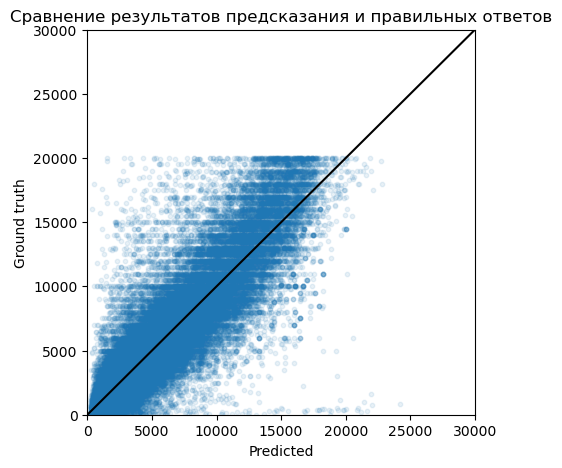

In [30]:
fig, ax = plt.subplots(figsize=(5,5))

scatter = ax.scatter(predictions, y_test, s=10, alpha=0.1)
line = ax.plot([0, 3e4], [0, 3e4], color='black')

plt.title('Сравнение результатов предсказания и правильных ответов')
plt.xlim([0, 3e4]);
plt.ylim([0, 3e4]);
plt.xlabel('Predicted');
plt.ylabel('Ground truth');
plt.show();

## Выводы

- Разработан бэйзлайн глубокого обучения на примере задачи регрессии.  
- Полученная модель дает чуть большую погрешность в определении цены автомобиля RMSE = 1991 евро, чем классические модели машинного обучения, обученные в предыдущем проекте (у модели Light GBM Regressor RMSE = 1606 евро).  
- Для улучшения результатов необходимо ислледовать другие архитектуры сети и соответсвующие гиперпараметры, оптимизаторы, функции потерь.